In [1]:
# external dependencies
import numpy as np
import sys
import os
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric, get_body, get_body_barycentric_posvel, SkyCoord, EarthLocation, Angle

In [2]:
# some useful constants in SI units
degrees = np.pi/180.
mas = degrees/1000./3600.
hour = 3600.
year = 365.25*24.*hour
au = 149597870700. #m
pc = 648000./np.pi*au #m
v_c = 299792458.
minute = 60.
day = 24.*hour
mHz = 1.0e-3
MHz = 1.0e+6
GHz = 1.0e+9
mus = 1.0e-6
sqrtmus = np.sqrt(mus)
kms = 1000.

Insert the path according to your choice in the next cell:

In [3]:
# import scinter
sys.path.insert(0,'/path/to/Scinter3')
import scinter_data
import scinter_plot
import scinter_measurement
import scinter_computation

# set up storage of data and analysis products
storage = scinter_measurement.storage("/path/to/example_results/")

In [4]:
# define telescopes
Effelsberg = EarthLocation.from_geodetic(Angle('50°31′29″'),Angle('6°52′58″'),height=319.)
LOFAR = EarthLocation.from_geodetic(Angle('52°54′19″'),Angle('6°52′5″'),height=23.)
Arecibo = EarthLocation.from_geodetic(Angle('18°20′39″'),Angle('-66°45′10″'),height=497.)
GreenBank = EarthLocation.from_geodetic(Angle('38°26′16″'),Angle('-79°50′10″'),height=818.)
JodrellBank = EarthLocation.from_geodetic(Angle('53°14′10″'),Angle('-2°18′26″'),height=77.)
Westerbork = EarthLocation.from_geodetic(Angle('52°54′53″'),Angle('6°36′12″'),height=17.)

In [5]:
# example source: PSR B1237+25
psrname = 'PSR1237+25' # readable from astropy; alternatively provide coordinates as SkyCoord object
D_s = 840. # distance in parsec
PMRA = -104.5 # proper motion along right ascension in milliarcseconds per year
PMDEC = 49.4 # proper motion along declination in milliarcseconds per year
PM = np.sqrt(PMRA**2+PMDEC**2)*mas/year*D_s*pc
print("Proper motion: {0} km/s".format(PM/kms))

Proper motion: 460.271277756883 km/s


In [6]:
# example observation: 1 hour L-band at Effelsberg on 1 March 2023
telcoords = Effelsberg
mjd_start = 60004. #1 March 2023
dt = 10. # ten seconds subintegrations
N_t = 360 # number of time bins
t = np.arange(N_t)*dt
mjds = mjd_start+t/day
mjd0 = np.mean(mjds) # central time of observation
N_nu = 800 # number of frequency bins
nu_min = 1.3*GHz
nu_max = 1.45*GHz
nu = np.linspace(nu_min,nu_max,num=N_nu)
nu0 = np.mean(nu) # center of band
dnu = nu[1]-nu[0]

# compute accessible range and resolution in secondary spectrum
tau_lim = 1./dnu
fD_lim = 1./dt
tau_max = tau_lim/2.
dtau = 1./(nu_max-nu_min)
fD_max = fD_lim/2.
dfD = 1./t[-1]
print("delay: range = {0} mus, resolution = {1} mus".format(tau_max/mus,dtau/mus))
print("rate: range = {0} mHz, resolution = {1} mHz".format(fD_max/mHz,dfD/mHz))

delay: range = 2.663333333333071 mus, resolution = 0.006666666666666667 mus
rate: range = 50.0 mHz, resolution = 0.2785515320334262 mHz


# Example 1: single 1D screen

In [7]:
# initialize reproducible random numbers
rng = np.random.default_rng(12345)

# set up storage of observation
obsname = "Single1Dscreen"
obs = storage.add_obs(obsname)

In [8]:
# define the screen
D_x = 200. # distance of screen in parsec
a_x = 50. # angle of screen in degrees 
V_x = 70. # ISM velocity along the screen in km/s

# initialize the screen
scr_1D = scinter_computation.OnTel_1DScreen(D_x=D_x,D_s=D_s,a_x=a_x,V_x=V_x,PMRA=PMRA,PMDEC=PMDEC)

# populate the screen with images
N_im = 40 # number of images
r_im = 4.*mas # extent of the screen centered around zero
for i in range(N_im):
    th = (rng.random()-0.5)*r_im # random image coordinate along screen axis
    mu = (rng.random() + 0.5)*np.exp(-th**2/r_im**2) # image amplitude decreasing with distance from center
    ph = 2.*np.pi*rng.random() # random image phase
    scr_1D.add_SP(th=th,mu=mu,ph=ph) # enter image
scr_1D.add_CP(mu=1.) # add central image comoving with line of sight

In [9]:
# add noise and pulse to pulse variations for realism
scr_1D.add_noise(noise_rms=0.1)
scr_1D.add_pulse_variation(noise_pulse=0.1)

# compute the electric field
E, p = scr_1D.compute_DS(t,nu,mjds,psrname,telcoords) # also returning the projected observer position p for interferometry
EF = scinter_data.generic_Efield(t,nu,E)

# save the data
obs.log_E(EF)
obs.log_p(p)

# compute and save dynamic spectrum
dynspec = np.abs(E)**2
dynspec = dynspec/np.std(dynspec) # scale by standard deviation of data
DS = scinter_data.generic_intensity(t,nu,dynspec,mjd0)
obs.log_DS(DS)

New electric field saved as /mnt/d/Ubuntu/MPIfR/example_results/Single1Dscreen/computations/EF.npz
New projected telescope position saved as /mnt/d/Ubuntu/MPIfR/example_results/Single1Dscreen/computations/p.npz
New DS saved as /mnt/d/Ubuntu/MPIfR/example_results/Single1Dscreen/computations/DS.npz


In [10]:
# alternatively load already existent data
obs = scinter_measurement.measurement(storage.data_path,obsname)
DS = scinter_data.intensity(obs.data_path)
EF = scinter_data.load_Efield(obs.data_path)

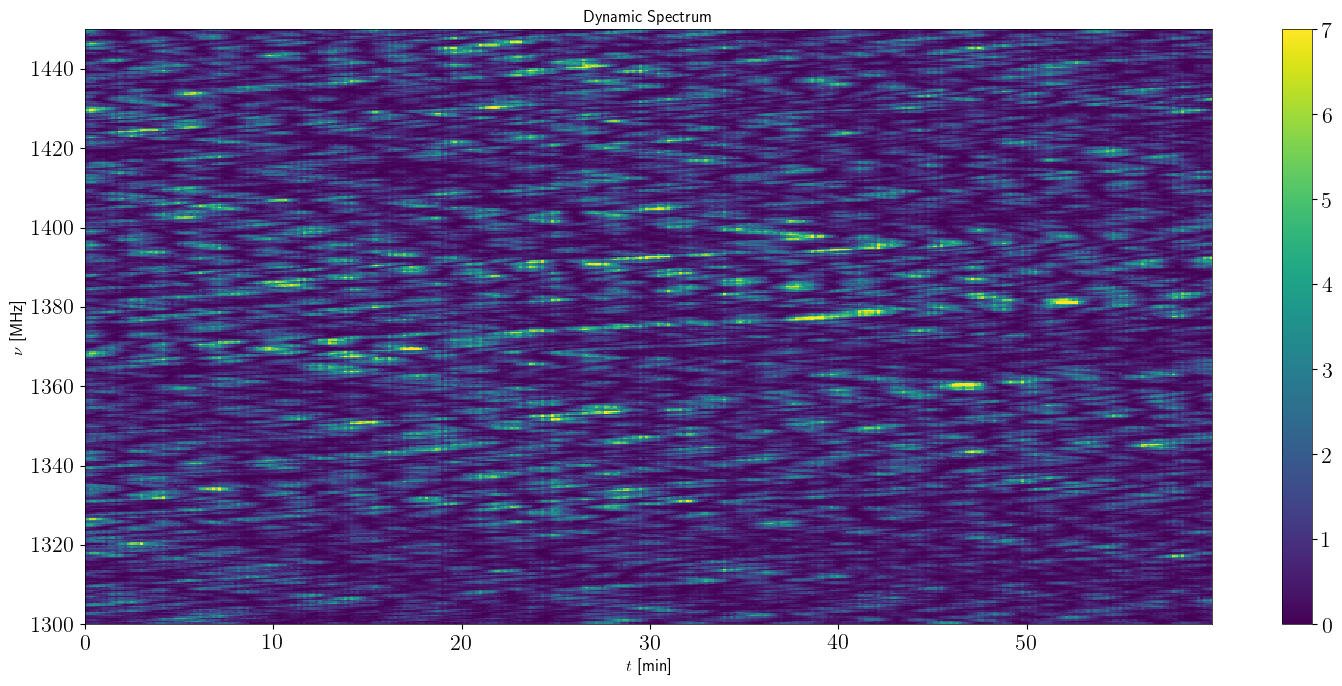

In [11]:
# plot dynamic spectrum
figure = scinter_plot.draw_canvas(plot_width = 1600,plot_height = 700, plot_bottom = 0.1, plot_left = 0.1, plot_wspace = 0.1, plot_hspace = 0.1, textsize=16, labelsize=12)
ax = figure.add_subplot(1,1,1)
plot = scinter_plot.dynamic_spectrum(DS.t,DS.nu,DS.DS,ax,vmin=0.,vmax=7.,nu_sampling=2)
figure.colorbar(plot, ax=ax)
figure.savefig(os.path.join(obs.obs_path,"DynSpec.png"))

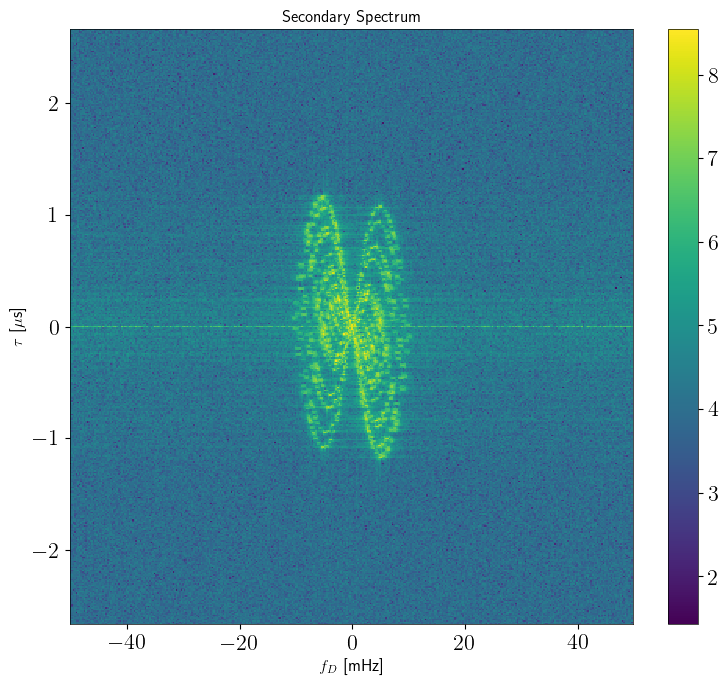

In [12]:
# compute secondary spectrum
# via FFT, saving the result, or loading it if already computed and overwrite==False
SS = scinter_data.SecSpec_FFT(DS,data_path=obs.data_path,overwrite=True)

# plot it
figure = scinter_plot.draw_canvas(plot_width = 800,plot_height = 700, plot_bottom = 0.1, plot_left = 0.1, plot_wspace = 0.1, plot_hspace = 0.1, textsize=16, labelsize=12)
ax = figure.add_subplot(1,1,1)
plot = scinter_plot.secondary_spectrum(SS.fD,SS.tau,SS.SS,ax,fD_sampling=1,tau_sampling=2,fD_min=None,fD_max=None,tau_min=None,tau_max=None,vmin=None,vmax=None)
figure.colorbar(plot, ax=ax)
figure.savefig(os.path.join(obs.obs_path,"SecSpec_FFT.png"))

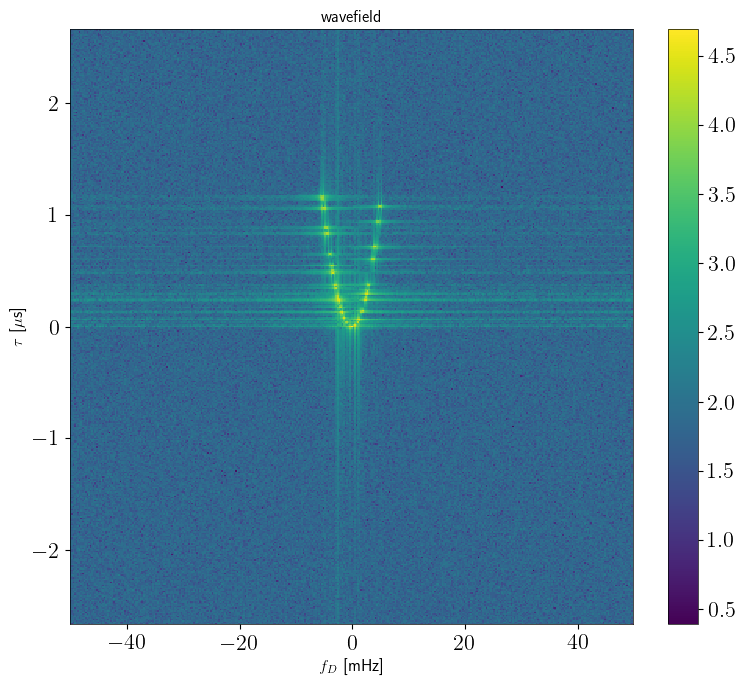

In [13]:
# compute wavefield
# via FFT, saving the result, or loading it if already computed and overwrite==False
# taking amplitudes from square root of dynamic spectrum and phases from electric field
WF = scinter_data.Wavefield_FFT(DS,EF,data_path=obs.data_path,overwrite=True)
# plot it
figure = scinter_plot.draw_canvas(plot_width = 800,plot_height = 700, plot_bottom = 0.1, plot_left = 0.1, plot_wspace = 0.1, plot_hspace = 0.1, textsize=16, labelsize=12)
ax = figure.add_subplot(1,1,1)
plot = scinter_plot.secondary_spectrum(WF.fD,WF.tau,WF.amplitude,ax,fD_sampling=1,tau_sampling=2,fD_min=None,fD_max=None,tau_min=None,tau_max=None,vmin=None,vmax=None,title="wavefield")
figure.colorbar(plot, ax=ax)
figure.savefig(os.path.join(obs.obs_path,"Wavefield_FFT.png"))